## Package Installaion

In [39]:
%pip install statsmodels


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
%pip install neuralprophet
%pip install matplotlib
%pip install seaborn
%pip install pickle


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Package Importation

In [41]:
from neuralprophet import NeuralProphet, set_random_seed, set_log_level; set_random_seed(314159); set_log_level("ERROR", "INFO")
from neuralprophet.df_utils import make_future_df, fill_linear_then_rolling_avg, add_missing_dates_nan

import pandas as pd
import numpy as np

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True); sns.set_style("whitegrid")

import time

from collections import defaultdict

import copy

import pickle

## Reading Data

Below we read in the data for train, val and test as well as the associated historical dataframe

In [42]:
df = pd.read_csv('../data_processing/final_dataset/5_year.csv', index_col=0)

In [43]:
train = pd.read_csv('../data_processing/train_final.csv', index_col=0).T
val = pd.read_csv('../data_processing/val_final.csv', index_col=0).T
test = pd.read_csv('../data_processing/test_final.csv', index_col=0).T

In [44]:
earnings_10yr_df = pd.read_csv('../data_processing/earnings_10yr_past_future_df.csv')

In [45]:
CES_dates_df = pd.DataFrame(
    {
        "event": "CES Show",
        "ds": pd.to_datetime(
            [
                "2012-01-11",
                "2013-01-10",
                "2013-01-09",
                "2014-01-05",
                "2015-01-09",
                "2016-01-07",
                "2017-01-06",
                "2018-01-10",
                "2019-01-09",
                "2020-01-08",
                "2021-01-12",
                "2022-01-05",
                "2023-01-06",
            ]
        ),
    }
)

AAPL_dates_df = pd.DataFrame(
    {
        "event": "AAPL Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['aapl']
        ),
    }
)

META_dates_df = pd.DataFrame(
    {
        "event": "META Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['meta']
        ),
    }
)

GOOG_dates_df = pd.DataFrame(
    {
        "event": "GOOG Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['goog']
        ),
    }
)

NFLX_dates_df = pd.DataFrame(
    {
        "event": "NFLX Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['nflx']
        ),
    }
)

AMZN_dates_df = pd.DataFrame(
    {
        "event": "AMZN Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['amzn']
        ),
    }
)

MSFT_dates_df = pd.DataFrame(
    {
        "event": "MSFT Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['msft']
        ),
    }
)

NVDA_dates_df = pd.DataFrame(
    {
        "event": "NVDA Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['nvda']
        ),
    }
)

AMD_dates_df = pd.DataFrame(
    {
        "event": "AMD Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['amd']
        ),
    }
)

INTC_dates_df = pd.DataFrame(
    {
        "event": "INTC Earnings",
        "ds": pd.to_datetime(
            earnings_10yr_df['intc']
        ),
    }
)
event_names = [
    'CES Show',
    'AAPL Earnings', 
    'META Earnings', 
    'GOOG Earnings', 
    'NFLX Earnings', 
    'AMZN Earnings',
    'MSFT Earnings',
    'NVDA Earnings',
    'AMD Earnings',
    'INTC Earnings',
]
events_df = pd.concat(
    (
        CES_dates_df,
        AAPL_dates_df,
        META_dates_df,
        GOOG_dates_df,
        NFLX_dates_df,
        AMZN_dates_df,
        MSFT_dates_df,
        NVDA_dates_df,
        AMD_dates_df,
        INTC_dates_df
    ),
)

In [46]:
base_model = NeuralProphet(
    growth='discontinuous',  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=52, # Number of weeks in a month, looks at a potential changepoint evey month
    trend_reg=0, # Changed to 0 for no flexibility in selection of changepoints
    trend_reg_threshold=False, # Requires regularization for trend to be changed
    yearly_seasonality=True, # Automatically fits yearly seasonality
    weekly_seasonality='auto', # Automatically fits weekly seasonality
    daily_seasonality='auto', # Automatically fits daily seasonality
    seasonality_mode='additive', # Additional (adds) seasonality instead of multiplicative (multiplies) seasonality
    seasonality_reg=0, # Due to the dataset being based on bike shares, visually will be very impacted by seasonality: set at maximum
    n_forecasts=1, # Set at default 1 for forecasting one step ahead
    n_lags=7, # To include 7 days worth of AR lag
    num_hidden_layers=0, # 8 hidden layers for the network
    d_hidden=0, # Dimension of hidden layers of AR-Net
    learning_rate=None, # Automatically determines learning rate
    epochs=None, # Automatically sets the learning rate (based on data size)
    loss_func='Huber', # Sets Huber loss function for robustness to outliers ### Describe Huber in presentation/write-up
    # normalize='auto',  # Type of normalization ('minmax', 'standardize', 'soft', 'auto', None) ## Why normalize again?
)
base_model.add_country_holidays("US")

In [47]:
industry_symbol = df['Symbol']

In [48]:
index_to_symbol_map = industry_symbol.to_dict()
symbol_to_index_map = dict(zip(index_to_symbol_map.values(), index_to_symbol_map.keys()))

In [49]:
for symbol in industry_symbol:
    set_random_seed(0)
    model = copy.deepcopy(base_model)

    model.add_events(event_names)

    train_inp = pd.DataFrame(train[symbol_to_index_map[symbol]])
    train_inp=train_inp.reset_index()
    train_inp=train_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
    val_inp = pd.DataFrame(val[symbol_to_index_map[symbol]])
    val_inp=val_inp.reset_index()
    val_inp=val_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})




    historical_train_df = model.create_df_with_events(train_inp, events_df)
    historical_val_df = model.create_df_with_events(val_inp, events_df)

    metrics = model.fit(
        df=historical_train_df,
        freq='D',
        validation_df=historical_val_df,
        progress='bar'
    )




    ## Pickling model and metrics
    model_path = '../model/model_added/' + symbol +'_added_model.pickle'
    metrics_path = '../model/metrics_added/' + symbol+'_added_metric.pickle'


    with open(model_path, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(metrics_path, 'wb') as handle:
        pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/ryanjang123/cardiac_arrest/lib/python3.9/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([263])) that is different to the input size (torch.Size([263, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



GEN : 0.30215726125343856 0.23013799715341998
AKAM : 1.7239223247853757 1.3715914792234793
MSFT : 2.6832326965164577 2.0578563234341223
JKHY : 5.960016934598526 5.407599078484301
STX : 1.5304786179933267 1.360818594206804
APH : 1.5690656663907196 1.2929142142241856
AAPL : 2.083212963354313 1.8314482922823923
AMAT : 2.0668925065183132 1.7723543778905326
TEL : 1.5132254582142435 1.1526376784222678
IBM : 2.0122891301364105 1.6100943511387074
MSI : 2.1617540087440372 1.6908588529382864
avg_rmse: 2.146022506227742
avg_mae: 1.7980282944907726


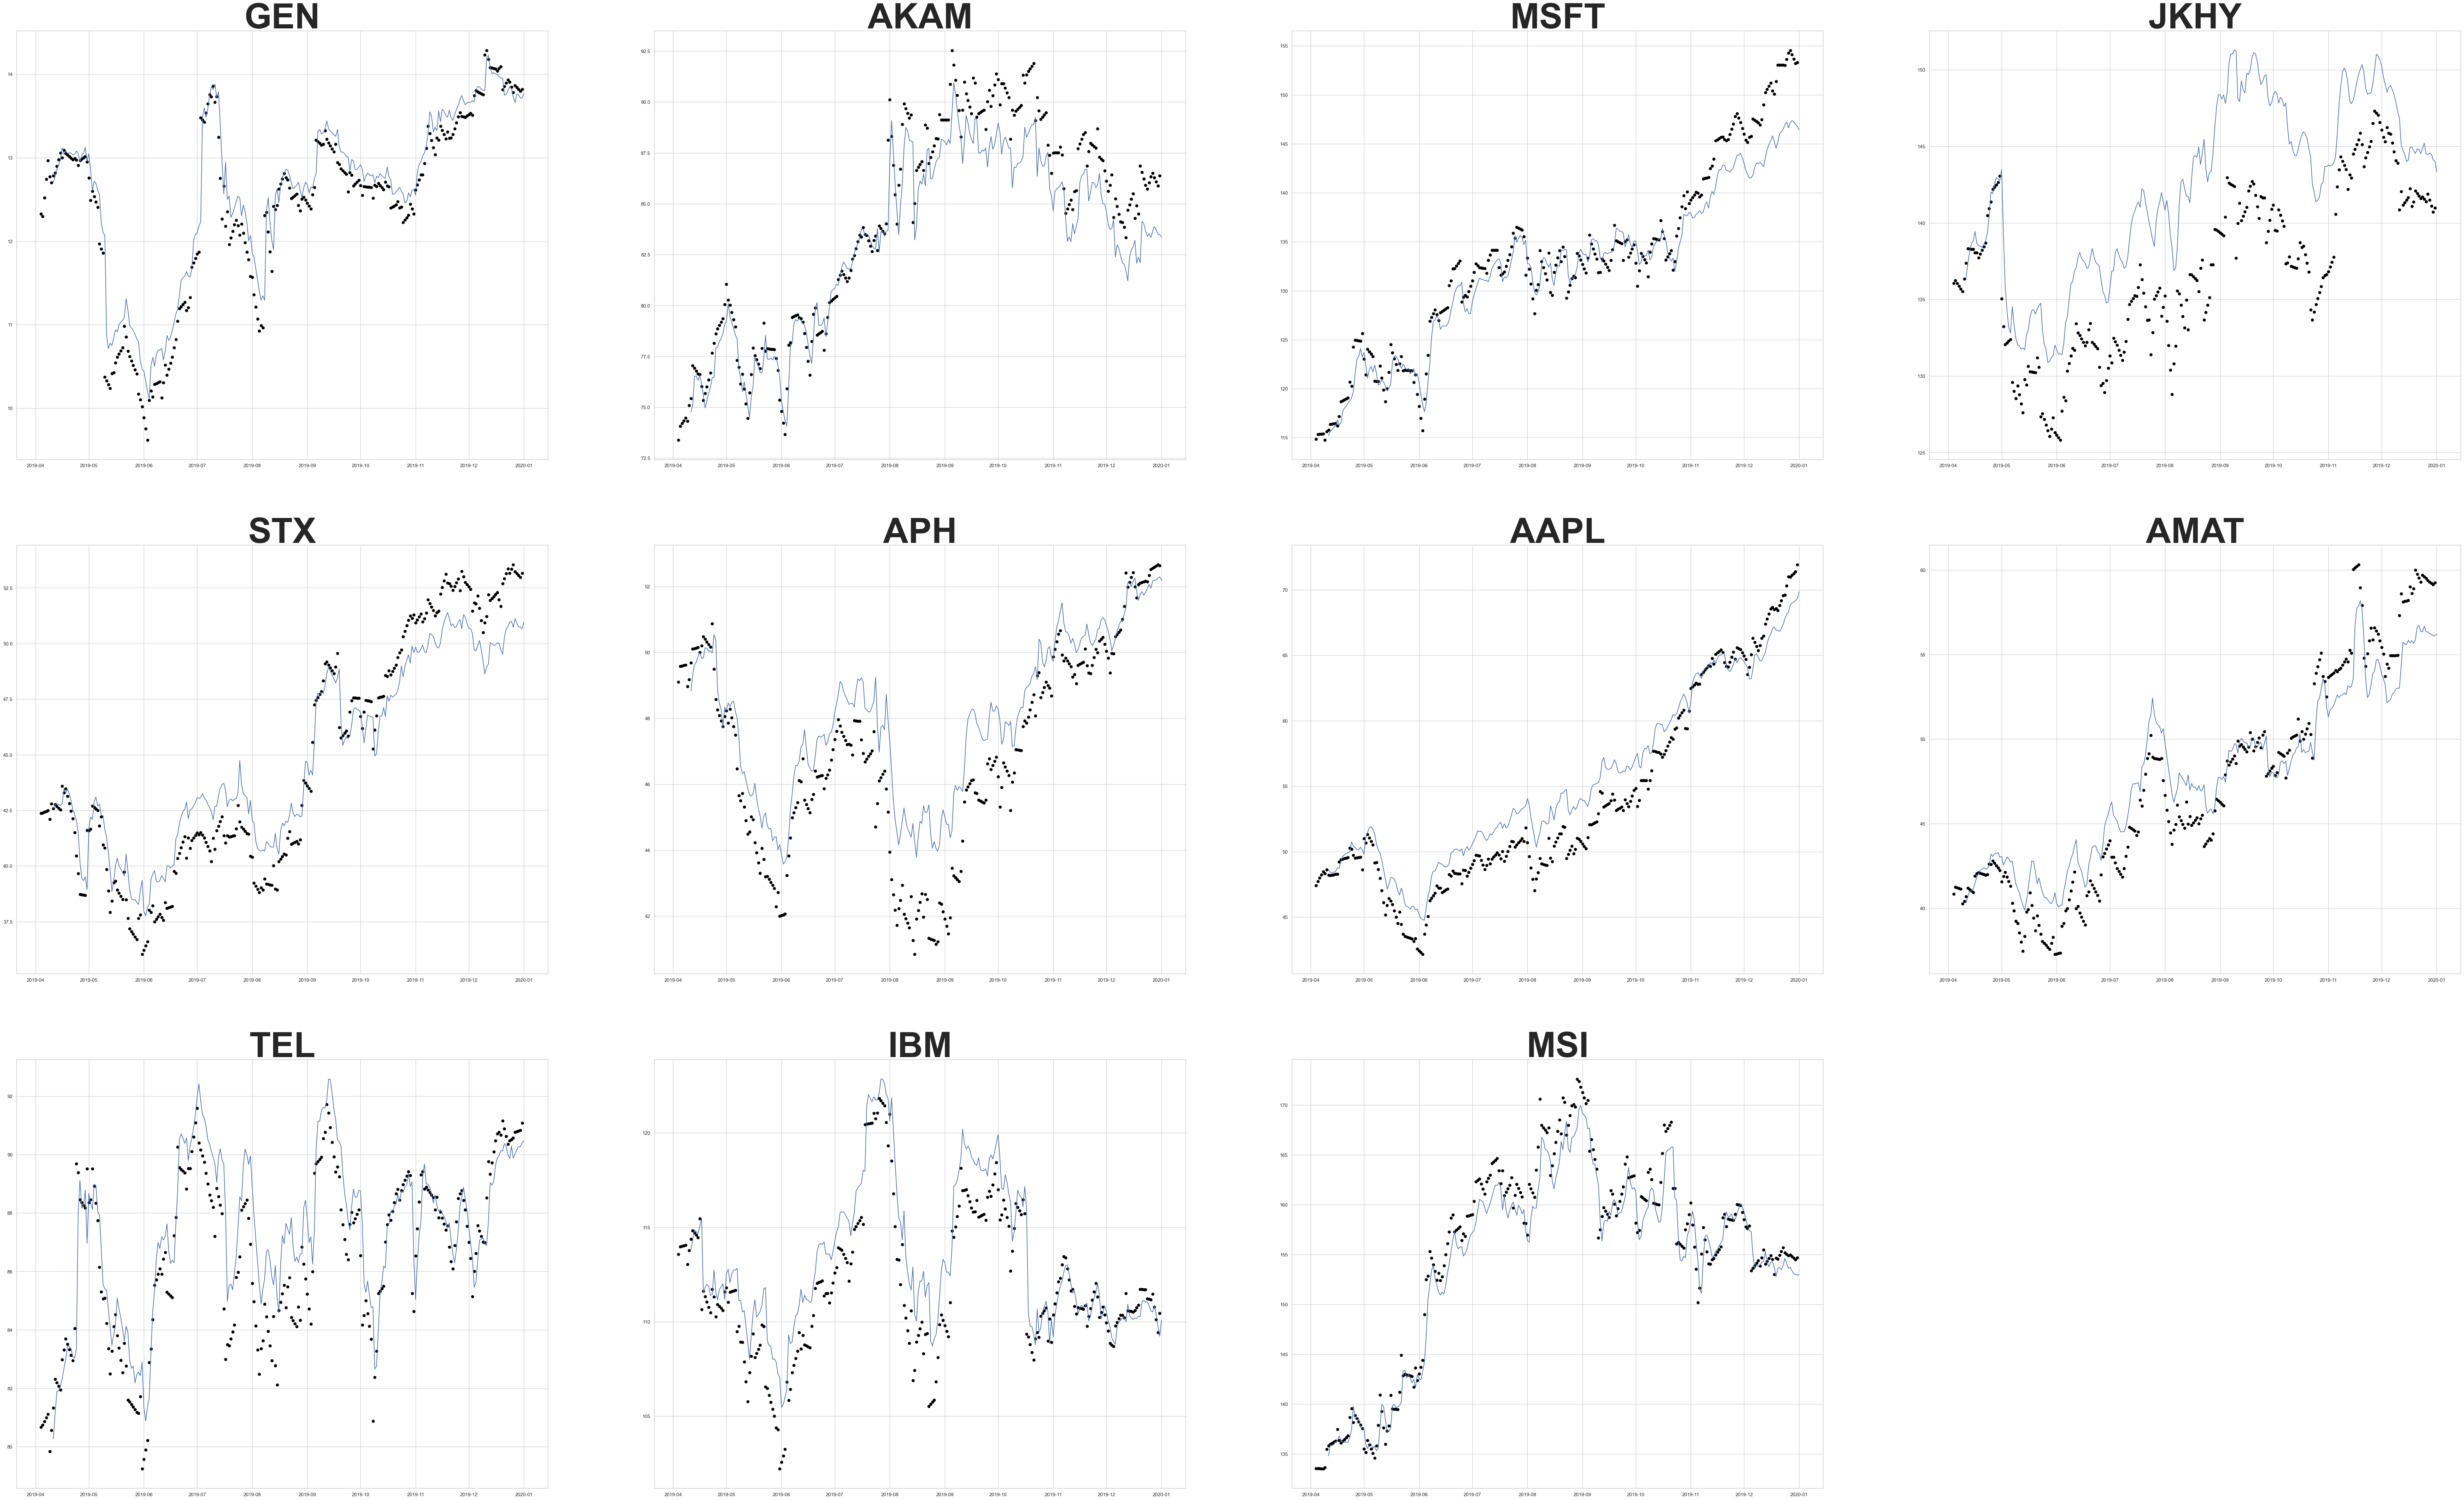

In [55]:
fig, ax = plt.subplots(3,4 , figsize = (100,60))
r= []
m = []
z = 0
# industry_symbol['Symbol'/]
for i in range(3):
    for j in range(4):
        ind = 4*i + j 
        if ind == len(industry_symbol):
            break
        z += 1
        symbol = industry_symbol[ind]
        filename = '../model/model_added/'+symbol+'_added_model.pickle'
        model = pickle.load(open(filename, 'rb'))
        test_inp = pd.DataFrame(test[symbol_to_index_map[symbol]])
        test_inp=test_inp.reset_index()
        test_inp=test_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
        historical_test_df = model.create_df_with_events(test_inp, events_df)
        future = model.make_future_dataframe(df=historical_test_df, periods=365, n_historic_predictions=len(historical_test_df))
        forecast = model.predict(df=future)
        rmse = np.average(forecast['residual1'][7:-1]**2)**(1/2)
        mae = np.average(np.abs(forecast['residual1'][7:-1]))
        r.append(rmse)
        m.append(mae)
        print(symbol, ':', rmse, mae)
        ax[i,j].scatter(forecast['ds'],forecast['y'], c = 'black')
        ax[i,j].plot(forecast['ds'],forecast['yhat1'])
        ax[i,j].set_title(symbol,fontweight='bold', size=80)

ax[2,3].axis('off')
print('avg_rmse:' , sum(r)/z)
print('avg_mae:',  sum(m)/z)
plt.show()

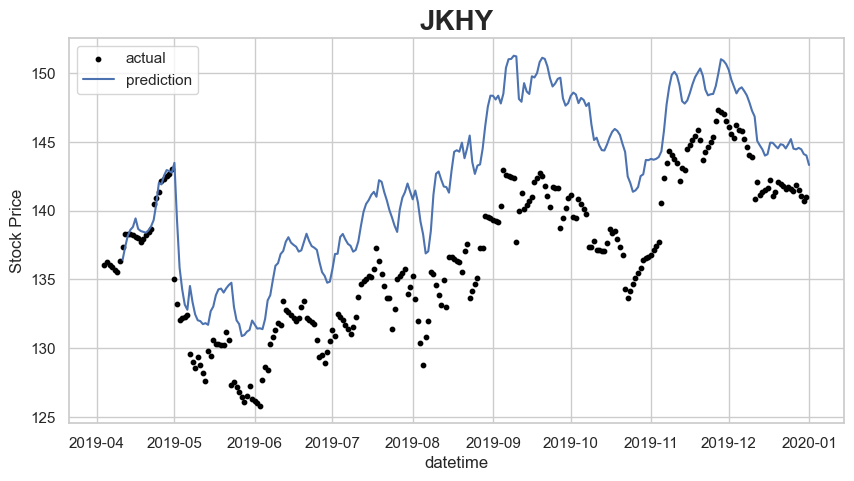

In [51]:
symbol = 'JKHY'
filename = '../model/model_added/'+symbol+'_added_model.pickle'
model = pickle.load(open(filename, 'rb'))
test_inp = pd.DataFrame(test[symbol_to_index_map[symbol]])
test_inp=test_inp.reset_index()
test_inp=test_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
historical_test_df = model.create_df_with_events(test_inp, events_df)
future = model.make_future_dataframe(df=historical_test_df, periods=365, n_historic_predictions=len(historical_test_df))
forecast = model.predict(df=future)
plt.figure(figsize=(10,5))
plt.scatter(forecast['ds'],forecast['y'], c = 'black', s = 10)
plt.plot(forecast['ds'],forecast['yhat1'])
plt.legend(['actual', 'prediction'])
plt.title(symbol,fontweight='bold', size=20)
plt.xlabel('datetime') 
plt.ylabel('Stock Price') 


plt.show()

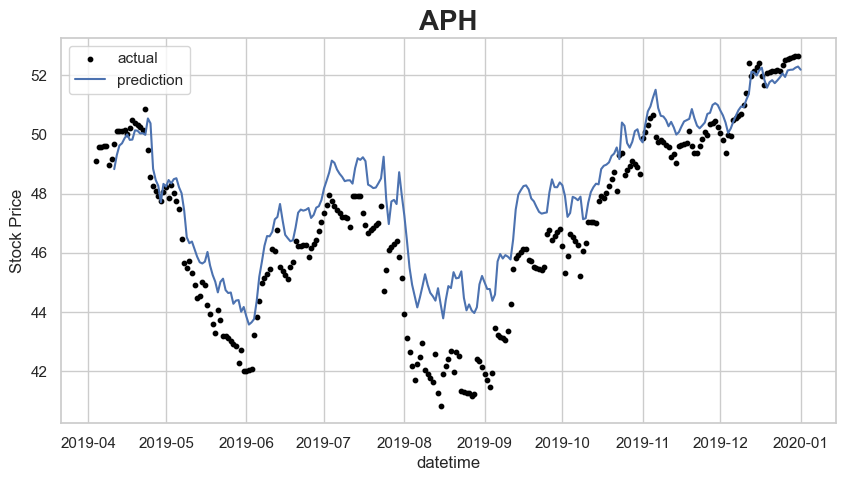

In [52]:
symbol = 'APH'
filename = '../model/model_added/'+symbol+'_added_model.pickle'
model = pickle.load(open(filename, 'rb'))
test_inp = pd.DataFrame(test[symbol_to_index_map[symbol]])
test_inp=test_inp.reset_index()
test_inp=test_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
historical_test_df = model.create_df_with_events(test_inp, events_df)
future = model.make_future_dataframe(df=historical_test_df, periods=365, n_historic_predictions=len(historical_test_df))
forecast = model.predict(df=future)
plt.figure(figsize=(10,5))
plt.scatter(forecast['ds'],forecast['y'], c = 'black', s = 10)
plt.plot(forecast['ds'],forecast['yhat1'])
plt.legend(['actual', 'prediction'])
plt.title(symbol,fontweight='bold', size=20)
plt.xlabel('datetime') 
plt.ylabel('Stock Price') 


plt.show()